In [1]:
#import all dependencies
import glob
from math import pi
import numpy as np
# from scipy import ndimage
# from scipy import linalg
# from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import pdb 
import cv2 as cv

In [22]:
class CannyEdgeDetector():
    def __init__(self,
                 image,
                 sigma,
                 kernel_size,
                 high_th_ratio,
                 low_th_ratio):
        '''
        image: np array
        sigma: std dev of gaussian kernel (int of float)
        kernel_size: # of datapoints in gaussian kernel (odd/even)
        high_th_ratio: ratio of high threshold and the max image intensity (int or float)
        low_th_ratio: ratio of low threshold and the max image intensity (int or float)
        
        '''

        self.image = image
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.high_th_ratio = high_th_ratio
        self.low_th_ratio = low_th_ratio

    def get_gaussian_mask1d(self, kernel_size, sigma):
        '''
        Returns a 1d gaussian kernel of shape (kernel_size, 1) and its derivative
        ---------------
        sigma: std dev of gaussian kernel (int of float)
        kernel_size: # of datapoints in gaussian kernel (odd/even)
        '''

        #handle even kernel size
        if kernel_size % 2 == 0:
            kernel_size += 1

        #detemine the number of datapoints from the center
        n = kernel_size // 2

        #initiate kernel and derivative with zero values
        kernel = np.zeros([kernel_size, 1])
        d_kernel = np.zeros([kernel_size, 1])

        #replace each element in the kernels with corresponding gaussian and derivative
        for x in range(-n, n+1):
            kernel[x+n, :] = np.exp(-(x**2)/ (2*(sigma**2)))
            d_kernel[x+n, :] = kernel[x+n, :]  * (-x)/(sigma**2)

        #return the kernels
        return kernel.T, d_kernel.T
    

    def apply_conv(self, image, kernel):
        '''
        applies convolution on image patches using 1d kernel
        ----------------
        image, kernel: self explanatory, both array
        '''

        #flip kernel
        flipped_kernel = np.flip(kernel, axis=(0,1))

        #calculate required number of padding in each direction of image to keep
        #output shape similar as input image
        padding_x = kernel.shape[1] // 2
        padding_y = kernel.shape[0] // 2

        #vreate padded image
        padded_image = np.pad(image, ((padding_y, padding_y), (padding_x, padding_x)), mode='constant')

        #initiate output image with zeros
        output = np.zeros([image.shape[0], image.shape[1]])

        #handle kernel orientation
        for y in range(padded_image.shape[0]- kernel.shape[0] + (kernel.shape[0] % 2)):
            for x in range(padded_image.shape[1]- kernel.shape[1] + (kernel.shape[1] % 2)):
                #isolate image shape with same shape as kernel
                if padding_x == 0:
                    image_patch = padded_image[y:(y+kernel.shape[0]), [x]]
                elif padding_y == 0:
                    image_patch = padded_image[[y], x:(x+kernel.shape[1])]
                
                #get convolution result
                output[y,x] = np.sum(image_patch * flipped_kernel)

        return output
    
    def apply_non_max_supression(self, image, theta):
        '''
        applies non-max suppression on edges to keep only true edge pixels
        -----------
        theta: orientation of edge pixels w.r.t to x-axis (np array)
        '''

        #initiate the non-max-suppressed image with zeros
        nms_image = np.zeros(image.shape)
        #since we consider pixels in both directions of orientation vector,
        #theta is bound within [0,pi]
        theta[theta < 0] += pi

        #check each element in image gradient magnitude array
        for r in range(1, image.shape[0]-1):
            for c in range(1, image.shape[1]-1):
                #initiate pixels along both directions
                pixel_1, pixel_2 = 0,0

                #check orientation angle within each pi/4 angular distance and choose two pixels accordingly
                if (0 <= theta[r, c] < pi/8) or (7*pi/8 <= theta[r, c] <= pi):
                    pixel_1 = image[r, c+1]
                    pixel_2 = image[r, c-1]
                elif (pi/8 <= theta[r, c] < 3*pi/8):
                    pixel_1 = image[r+1, c+1]
                    pixel_2 = image[r-1, c-1]
                elif (3*pi/8 <= theta[r, c] < 5*pi/8):
                    pixel_1 = image[r+1, c]
                    pixel_2 = image[r-1, c]
                elif (5*pi/8 <= theta[r, c] < 7*pi/8):
                    pixel_1 = image[r+1, c-1]
                    pixel_2 = image[r-1, c+1]

                #if center pixel is larger than both of the pixels, then keep it as such
                #else suppress to zero
                if (image[r,c] >= pixel_1) and (image[r,c] >= pixel_2):
                    nms_image[r,c] = image[r,c]
                else:
                    nms_image[r,c] = 0

        return nms_image
    
    def apply_hysteresis_thresholding(self, image, high_th_ratio, low_th_ratio):
        '''
        applies hysteresis thresholding on image
        '''

        # Calculate high and low threshold for hysteresis from the ratio values
        high_th = image.max() * high_th_ratio
        low_th = image.max() * low_th_ratio

        # Initiate the thresholded image with zero pixels
        image_th = np.zeros(image.shape)

        # Pixels higher than the high threshold are considered edges
        image_th[image > high_th] = 255

        # Find pixels between the low and high thresholds and check neighbors
        edge_pixels = np.where((low_th <= image) & (image <= high_th))
        for r, c in zip(*edge_pixels):
            neighborhood = image[r-1:r+2, c-1:c+2]
            if np.any(neighborhood > high_th):
                image_th[r, c] = 255

        return image_th
    
    def edge_detection(self):
        '''
        applies canny edge detector on images
        '''

        #generate 1d gaussian kernel and the derivative kernel
        self.G, self.G_x = self.get_gaussian_mask1d(self.kernel_size, self.sigma)

        #get G_y
        self.G_y = self.G_x.T

        #apply gaussian kernel to reduce noise of image
        self.blurred_I_x = self.apply_conv(self.image, self.G)
        self.blurred_I_y = self.apply_conv(self.image, self.G.T)

        #get derviative of blurred image
        self.I_x = self.apply_conv(self.blurred_I_x, self.G_x)
        self.I_y = self.apply_conv(self.blurred_I_y, self.G_y)

        #get magnitude and orientation of derivative
        self.M_xy = np.sqrt(np.square(self.I_x) + np.square(self.I_y))
        self.M_xy = self.M_xy / self.M_xy.max() * 255
        self.theta = np.arctan2(self.I_y, self.I_x)

        #apply non-max_supression for thinner edges
        self.nms_I = self.apply_non_max_supression(self.M_xy, self.theta)

        #apply hysteresis thresholding to join/isolate edge detached pixels
        self.I_edge = self.apply_hysteresis_thresholding(self.nms_I,
                                                         self.high_th_ratio,
                                                         self.low_th_ratio)
        
        return self.I_edge


    def plot_result(self, sigma):
        '''
        plots edges detected by canny detector along with intermediate results
        '''
        self.sigma = sigma
        # fig, ax = plt.subplots(3,2, figsize= (10,10))
        # plt.subplot(321)
        # plt.imshow(self.blurred_I_x, cmap='gray')
        # plt.title(f'(a) blurred_I_x ($\sigma = ${sigma})')
        # plt.subplot(322)
        # plt.imshow(self.blurred_I_y, cmap='gray')
        # plt.title(f'(b) blurred_I_y ($\sigma = ${sigma})')
        # plt.subplot(323)
        # plt.imshow(self.I_x, cmap='gray')
        # plt.title(f'(c) $I_x$ ($\sigma = ${sigma})')
        # plt.subplot(324)
        # plt.imshow(self.I_y, cmap='gray')
        # plt.title(f'(d) $I_y$ ($\sigma = ${sigma})')
        # plt.subplot(325)
        # plt.imshow(self.M_xy, cmap='gray')
        # plt.title(f'(e) Gradient Magnitude ($\sigma = ${sigma})')
        # plt.subplot(326)
        # plt.imshow(self.I_edge, cmap='gray')
        # plt.title(f'(f) Canny Detected Edge ($\sigma = ${sigma})')  
        fig, ax = plt.subplots(3,2, figsize= (12,12))
        plt.subplot(321)
        plt.imshow(self.blurred_I_x, cmap='gray')
        plt.title(f'(a) blurred_I_x')
        plt.subplot(322)
        plt.imshow(self.blurred_I_y, cmap='gray')
        plt.title(f'(b) blurred_I_y')
        plt.subplot(323)
        plt.imshow(self.I_x, cmap='gray')
        plt.title(f'(c) $I_x$')
        plt.subplot(324)
        plt.imshow(self.I_y, cmap='gray')
        plt.title(f'(d) $I_y$')
        plt.subplot(325)
        plt.imshow(self.M_xy, cmap='gray')
        plt.title('(e) Gradient Magnitude')
        plt.subplot(326)
        plt.imshow(self.I_edge, cmap='gray')
        plt.title('(f) Canny Detected Edge')                    
        fig.suptitle(f'Rseults for $\sigma = ${sigma}')                  

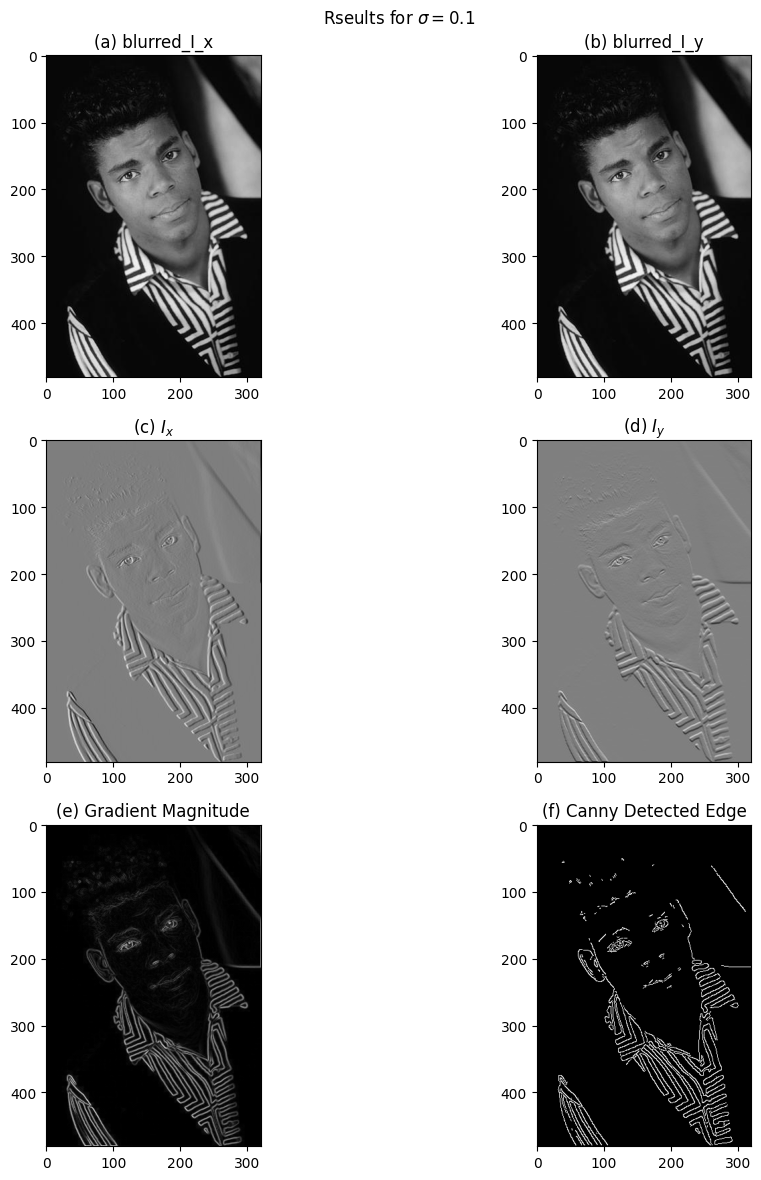

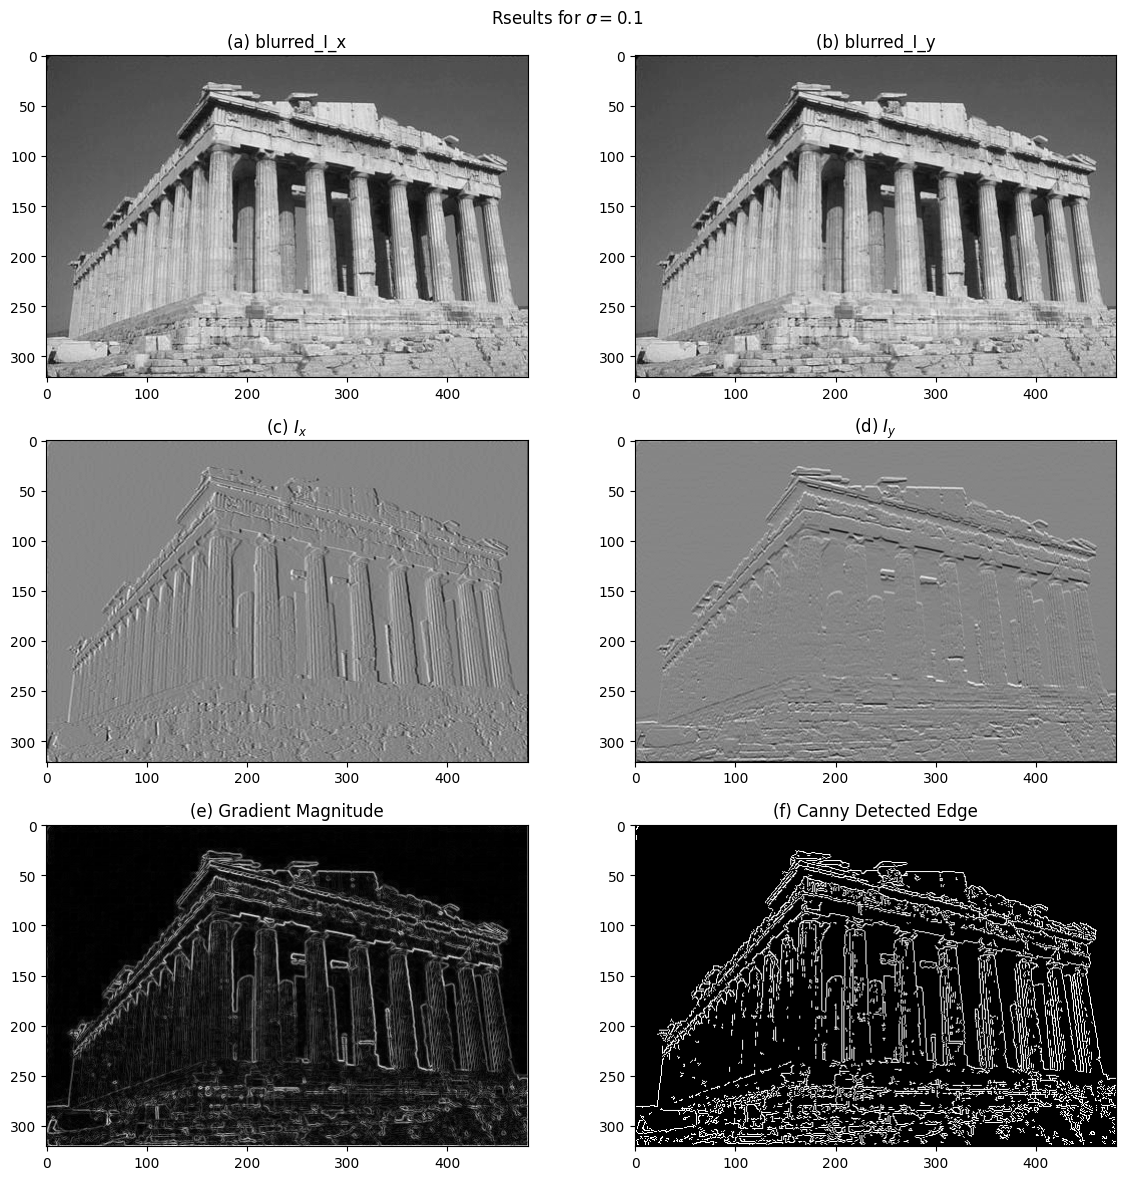

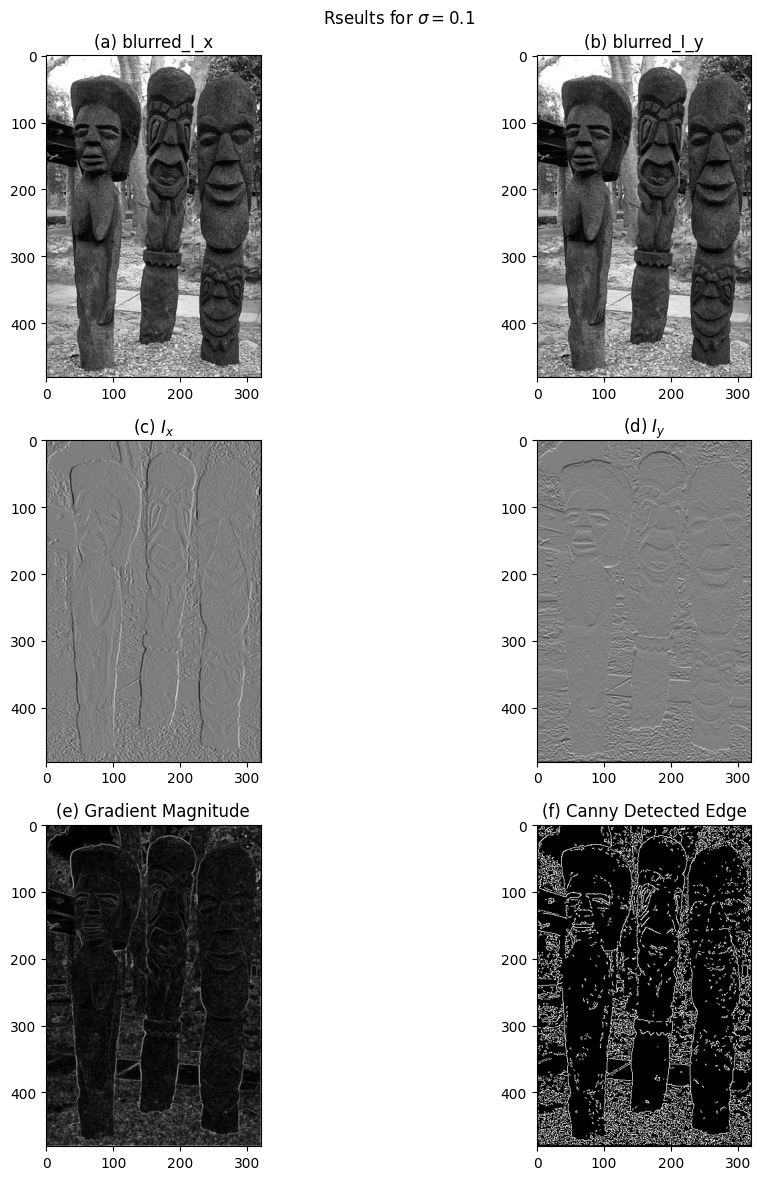

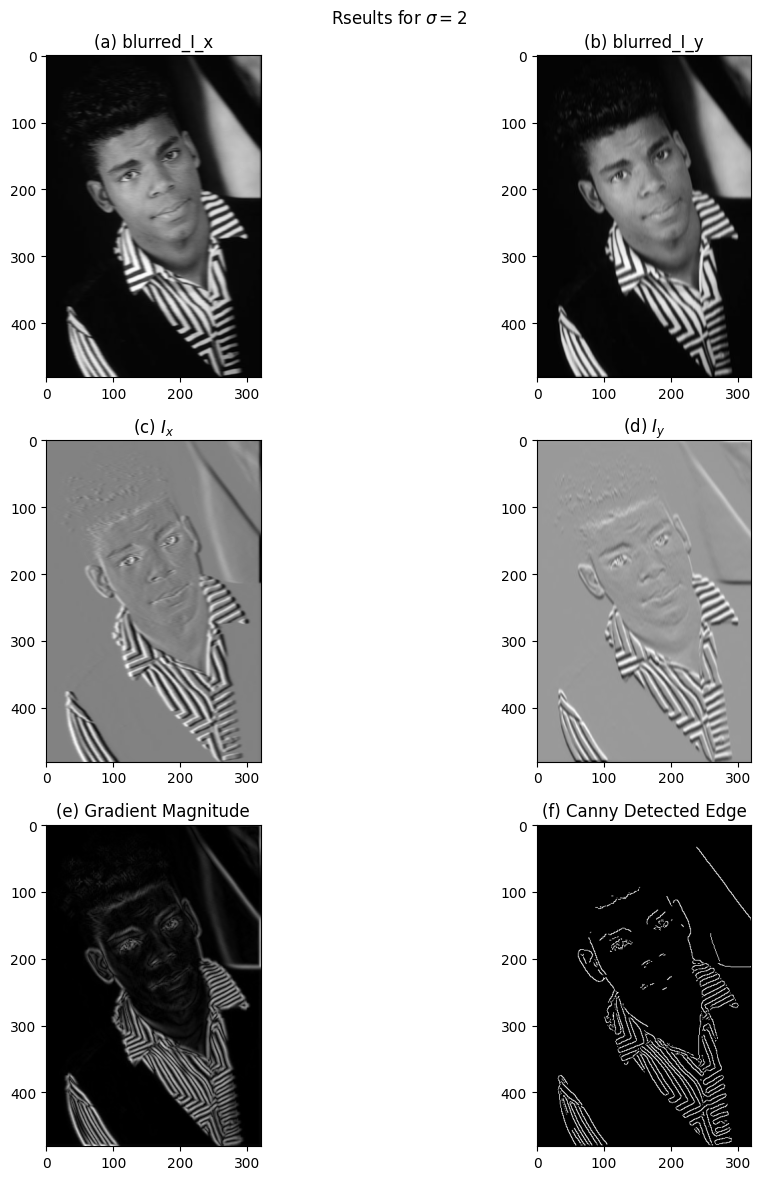

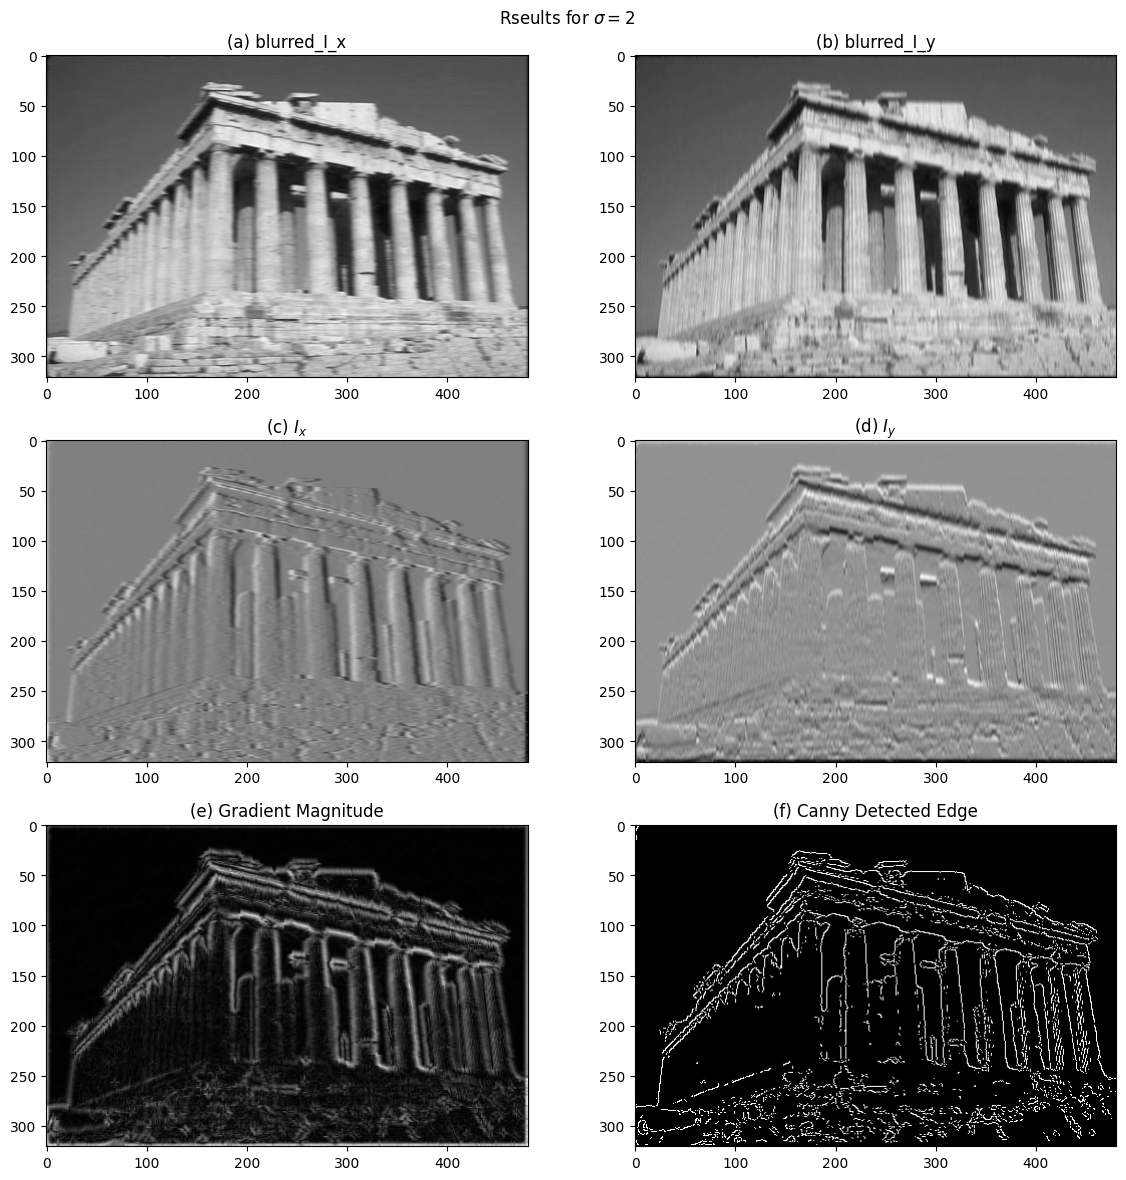

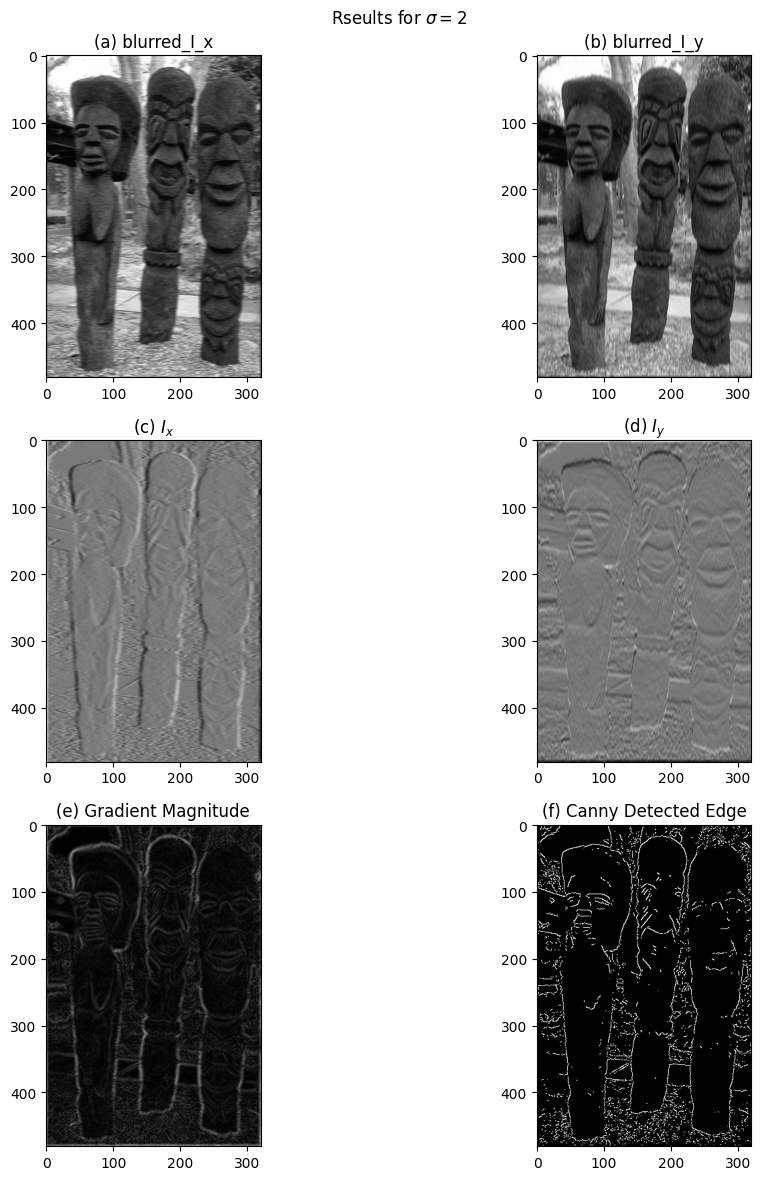

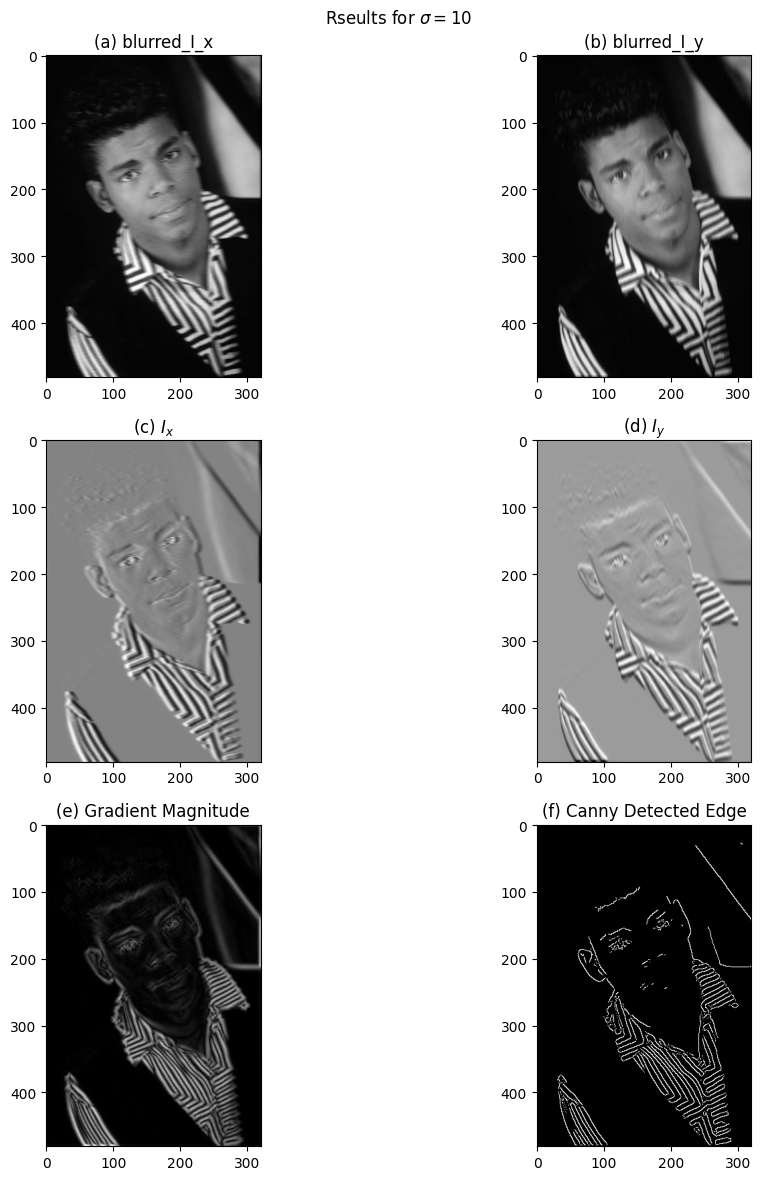

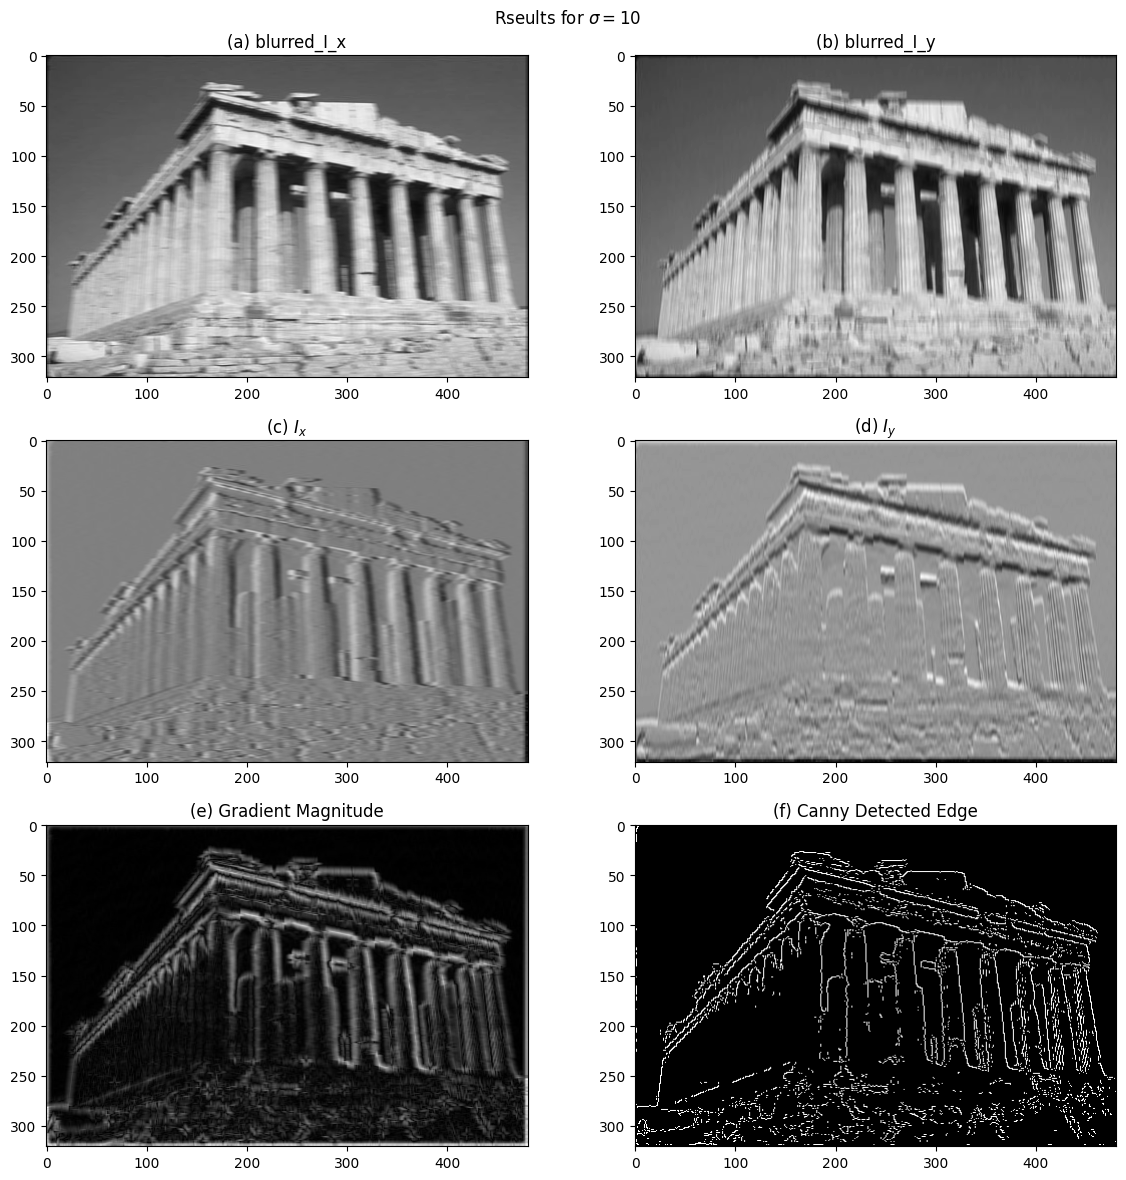

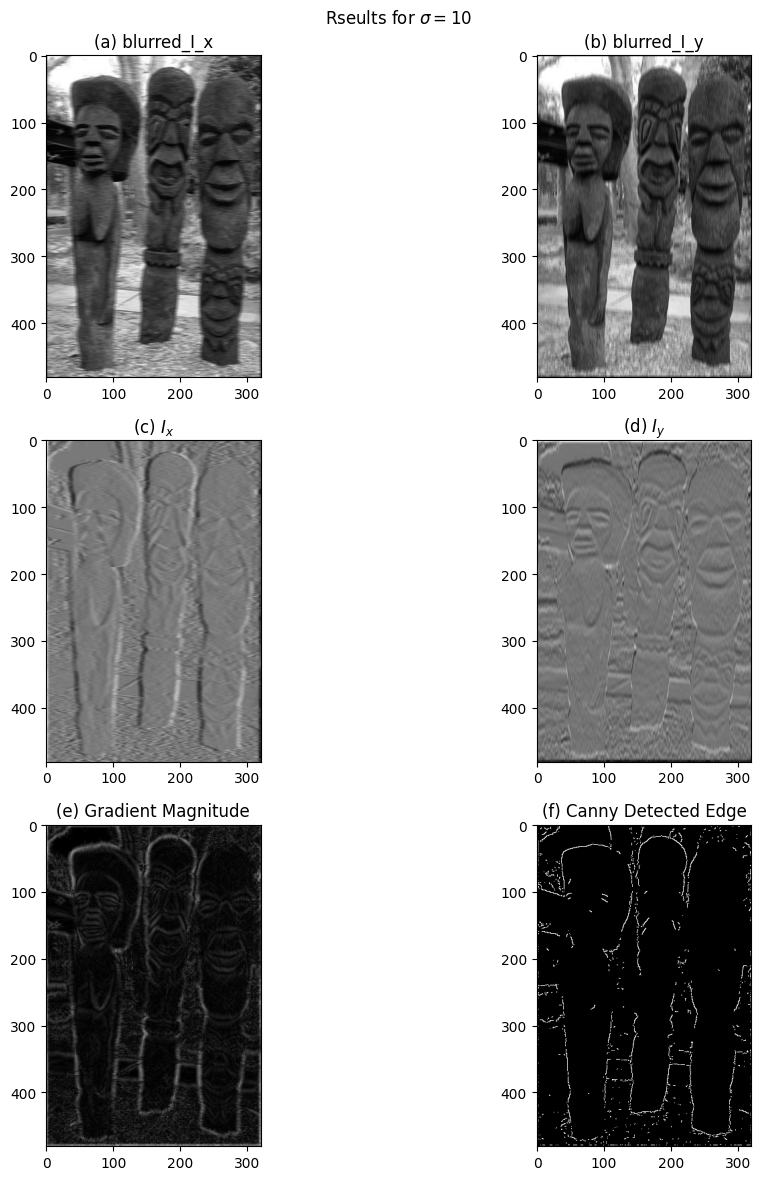

In [23]:
'''
main code
'''
# get all images from current directory
images = glob.glob('*.jpg')
sigma = sigma_list = [0.1, 2, 10]

for sigma in sigma:
#plot intermediate results
    for image in images:
        I = cv.imread(image, 0)
        #create an instance of CannyEdgeDetector class
        canny = CannyEdgeDetector(image=I, 
                                sigma=sigma,
                                kernel_size=7,
                                high_th_ratio=0.2,
                                low_th_ratio=0.08)
        
        #generate edges of image
        edge = canny.edge_detection()
        #generate resulted plots
        canny.plot_result(sigma=sigma)
        #save plots
        plt.tight_layout()
        plt.savefig(f"edge_{image.split('.')[0]}_sigma={sigma}.png")
        plt.show()

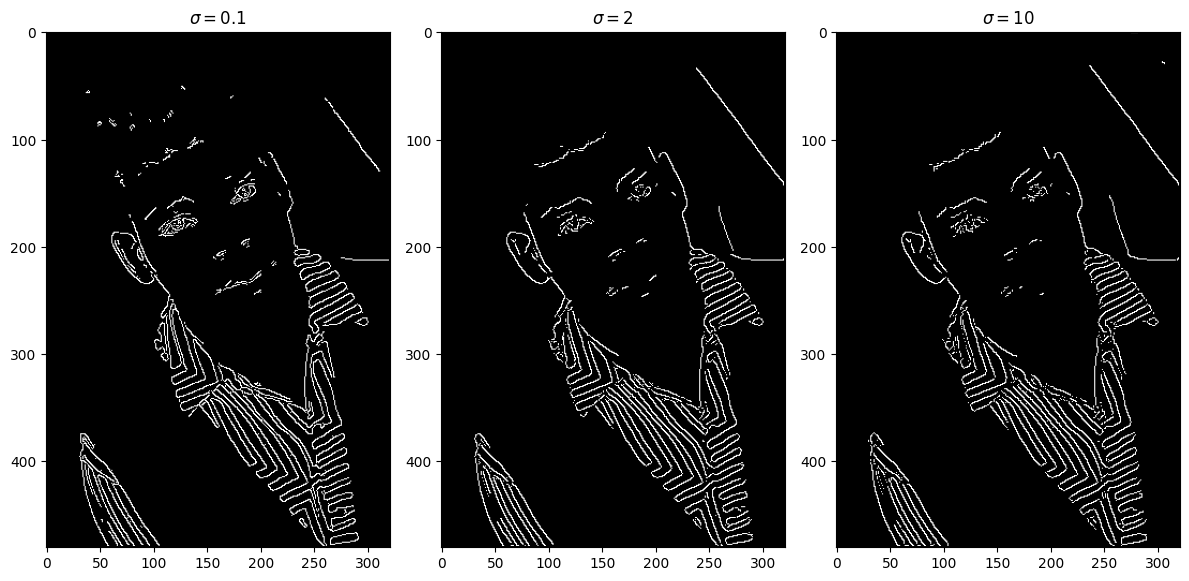

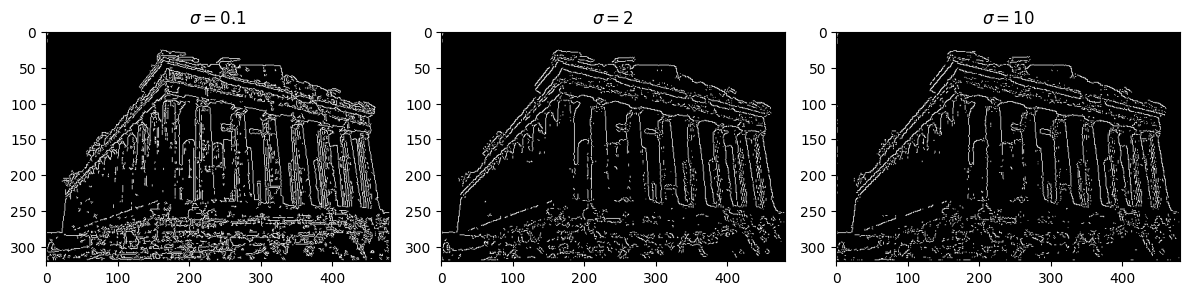

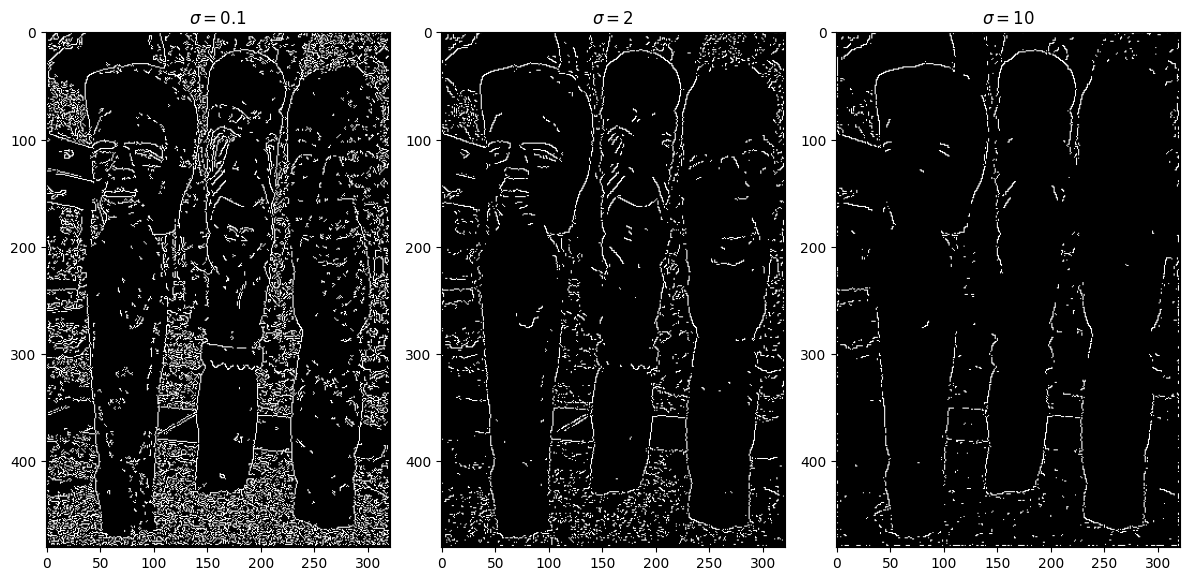

In [25]:
# do the experiments for varying sigma values
sigma_list = [0.1, 2, 10]

# plot canny edges varying the sigma
for image in images:
    # create subplot layout
    fig, ax = plt.subplots(1,3,figsize=(12,12))
    for i, sigma in enumerate(sigma_list):
        I = cv.imread(image, 0)
        # create an instance of CannyEdgeDetector class
        canny = CannyEdgeDetector(image=I,
                                  sigma=sigma, 
                                  kernel_size=7,
                                  high_th_ratio=0.2,
                                  low_th_ratio=0.08)
        
        #generate edges of image
        edge = canny.edge_detection()
        #plot results accordingly
        plt.subplot(1,3,i+1)
        plt.imshow(edge, cmap='gray')
        plt.title(f'$\sigma = ${sigma}')
    
    #save figures
    plt.tight_layout()
    plt.savefig(f"sigma_{image.split('.')[0]}.png")
    plt.show()